# Tutorial 3 - Variational classifier

In Tutorial 3 we considerably switch gears and show how to use openqml to implement variational classifiers - quantum circuits that can be trained from labelled data how to classify new data samples. 

Inspired by Farhi & Neven (2018), we will first train a variational classifier that encodes bitstring-inputs as basis states (*basis-encoding*) to learn the parity function

$$ f: x \in \{0,1\}^{\otimes n} \rightarrow y = \begin{cases} 1 \text{  if uneven number of ones in } x \\ 0 \text{ else} \end{cases}.$$

We then train a variational classifier that encodes real vectors as amplitude vectors (*amplitude encoding*) after Schuld, Bocharov, Wiebe and Svore (2018) on the first two classes of flowers in the Iris dataset.


## 1. Learning the parity function 

### Imports

In [1]:
import openqml as qm
from openqml import numpy as onp
import numpy as np
from openqml._optimize import GradientDescentOptimizer

from math import isclose

09:03:48 WARNING No OpenQML configuration file found.


### Quantum function

We create a quantum device with four "wires" or qubits.

In [2]:
#dev = qm.device('projectq.simulator', wires=2)
dev = qm.device('default.qubit', wires=4)

Variational classifiers usually define a "layer" or "block", which is an elementary circuit architecture that gets repeated to build the variational circuit.

<IMage>

Our circuit layer consists of an arbitrary rotation on every qubit, as well as CNOTs that entangle each qubit with its neighbour.

<IMage>

In [3]:
def layer(W):

    qm.Rot(W[0, 0], W[0, 1], W[0, 2], [0])
    qm.Rot(W[1, 0], W[1, 1], W[1, 2], [1])
    qm.Rot(W[2, 0], W[2, 1], W[2, 2], [2])
    qm.Rot(W[3, 0], W[3, 1], W[3, 2], [3])

    qm.CNOT([0, 1])
    qm.CNOT([1, 2])
    qm.CNOT([2, 3])
    qm.CNOT([3, 0])

We also need a way to encode data inputs $x$ into the circuit, so that the measured output depends on the inputs. In this first example, the inputs are bitstrings, which we encode into the state of the qubits. The quantum state $|\psi \rangle $ after state preparation is a computational basis state that has 1's where $x$ has 1s, for example

$$ x = 0101 \rightarrow |\psi \rangle = |0101 \rangle . $$

In [4]:
def statepreparation(x):

    for i in range(len(x)):
        if x[i] == 1:
            qm.PauliX([i])


Now we can elegantly define the quantum function as a state preparation routine, followed by a repitition of the layer structure.

In [5]:
@qm.qfunc(dev)
def variational_classifier(weights, x=None):

    statepreparation(x)

    for W in weights:
        layer(W)

    return qm.expectation.PauliZ(0)

Different from previous tutorials, the quantum function takes the data as a keyword argument `x=None`. A quantum function interprets all positional arguments as trainable variables, while keyword arguments stay fixed.

### Objective

The objective or cost in supervised learning is the sum of a loss and a regularizer. We use the standard square-loss that measures the distance between target labels and model predictions, as well as a standard l2 regularizer. 

In [6]:
def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss += (l-p)**2
    loss = loss/len(labels)
    return loss


def regularizer(weights):
    w_flat = weights.flatten()
    return onp.abs(onp.inner(w_flat, w_flat))

To monitor how many inputs the current classifier predicted correctly, we also define the accuracy given target labels and model predictions. 

In [7]:
def accuracy(labels, predictions):

    loss = 0
    for l, p in zip(labels, predictions):
        if isclose(l, p, abs_tol=1e-5):
            loss += 1
    loss = loss/len(labels)

    return loss

For learning tasks, the cost depends on the data - here the features and labels considered in the iteration of the optimization routine.

In [8]:
def cost(weights, features, labels):

    predictions = [variational_classifier(weights, x=x) for x in features]

    return square_loss(labels, predictions)

### Optimization

Let us load and preprocess some data. 

In [9]:
data = np.loadtxt("parity.txt")
X = data[:, :-1]
Y = data[:, -1]
Y = Y*2 - np.ones(len(Y)) # shift label from {0, 1} to {-1, 1}

for i in range(5):
    print("X = {}, Y = {}".format(X[i], Y[i]))
print("...")


X = [0. 0. 0. 0.], Y = -1.0
X = [0. 0. 0. 1.], Y = 1.0
X = [0. 0. 1. 0.], Y = 1.0
X = [0. 0. 1. 1.], Y = -1.0
X = [0. 1. 0. 0.], Y = 1.0
...


We split the data into training and validation set.

In [10]:
num_data = len(X)
num_train = int(0.75*num_data)
index = np.random.permutation(range(num_data))
X_train = X[index[: num_train]]
Y_train = Y[index[: num_train]]
X_val = X[index[num_train: ]]
Y_val = Y[index[num_train: ]]

Now initialize the weights randomly.

In [11]:
num_qubits = 4
num_layers = 2
weights0 = [np.random.randn(num_qubits, num_qubits)] * num_layers

weights0[0]

array([[ 3.02398027e-01,  6.29697451e-01, -9.11572123e-01,
         1.04791926e+00],
       [-8.01503118e-01,  1.51895353e+00,  7.15785719e-01,
         1.68189239e+00],
       [-6.01937508e-01,  1.36521061e-03,  8.15881485e-01,
         7.07507428e-01],
       [ 8.84260094e-01, -3.39068074e-01,  7.14015304e-01,
         1.84393128e+00]])

Create an optimizer...

In [12]:
o = GradientDescentOptimizer(0.01)
batch_size = 3

...and train the optimizer. We track the accuracy - the share of correctly classified data samples - on the training and validation set. For this we compute the outputs of the variational classifier and turn them into predictions in $\{-1,1\}$ by taking the sign of the output.

In [13]:
weights = np.array(weights0)
for iteration in range(5):

    # Update the weights by one optimizer step
    batch_index = np.random.randint(0, num_train, (batch_size, ))
    X_train_batch = X_train[batch_index]
    Y_train_batch = Y_train[batch_index]
    weights = o.step(lambda w: cost(w, X_train_batch, Y_train_batch), weights)

    # Compute predictions on train and validation set
    predictions_train = [np.sign(variational_classifier(weights, x=x)) for x in X_train]
    predictions_val = [np.sign(variational_classifier(weights, x=x)) for x in X_val]

    # Compute accuracy on train and validation set
    acc_train = accuracy(Y_train, predictions_train)
    acc_val = accuracy(Y_val, predictions_val)

    print("Iter: {:5d} | Cost: {:0.7f} | Acc train: {:0.7f} | Acc validation: {:0.7f} "
          "".format(iteration+1, cost(weights, X, Y), acc_train, acc_val))

Iter:     1 | Cost: 1.0751336 | Acc train: 0.5833333 | Acc validation: 0.2500000 
Iter:     2 | Cost: 1.1168455 | Acc train: 0.5833333 | Acc validation: 0.2500000 
Iter:     3 | Cost: 1.1674024 | Acc train: 0.5833333 | Acc validation: 0.2500000 
Iter:     4 | Cost: 1.2250436 | Acc train: 0.5833333 | Acc validation: 0.2500000 
Iter:     5 | Cost: 1.2873043 | Acc train: 0.5833333 | Acc validation: 0.2500000 
Iter:     6 | Cost: 1.3514038 | Acc train: 0.5833333 | Acc validation: 0.2500000 
Iter:     7 | Cost: 1.4146775 | Acc train: 0.5833333 | Acc validation: 0.2500000 
Iter:     8 | Cost: 1.4749240 | Acc train: 0.5833333 | Acc validation: 0.2500000 
Iter:     9 | Cost: 1.5305928 | Acc train: 0.5833333 | Acc validation: 0.2500000 
Iter:    10 | Cost: 1.5808085 | Acc train: 0.5833333 | Acc validation: 0.2500000 


## 2. Iris classification

To change from bit-string inputs to real-valued vectors, we simply overwrite the statepreparation function. Since we use four qubits, the quantum state has 16 amplitudes, and we encode $x$ into the first two qubits and again in the last two qubits. 

To save simulating a lengthy state preparation routine we use a hack: Compute $x \otimes x$ manually and set the amplitude vector to this value. *Note: Since we normalized $x$ earlier, $x \otimes x$ is also normalized!* 

In [14]:
def statepreparation(x):

    qm.QubitStateVector(onp.kron(x, x), wires=[0, 1, 2, 3])

We then load the Iris data set.

In [21]:
data = np.loadtxt("iris_scaled.txt")
X = data[:, :-1]
normalization = np.sqrt(np.sum(X ** 2, -1))
X = (X.T / normalization).T  # normalize each feature vector
Y = data[:, -1]
Y = Y*2 - np.ones(len(Y))  # shift label from {0, 1} to {-1, 1}

for i in range(5):
    print("X= {}, Y = {}".format(X[i], Y[i]))
print("...")

X= [-0.32588643  0.48071794 -0.56889588 -0.58229355], Y = -1.0
X= [-0.52103531 -0.11561943 -0.59097822 -0.60489594], Y = -1.0
X= [-0.62268821  0.11539688 -0.55884369 -0.53538461], Y = -1.0
X= [-0.69687166  0.0064708  -0.48273057 -0.53037649], Y = -1.0
X= [-0.37881314  0.54856308 -0.52088824 -0.53315532], Y = -1.0
...


As above, the data is split into training and validation set.

In [24]:
num_data = len(X)
num_train = int(0.75*num_data)
index = np.random.permutation(range(num_data))
X_train = X[index[: num_train]]
Y_train = Y[index[: num_train]]
X_val = X[index[num_train: ]]
Y_val = Y[index[num_train: ]]

Again we optimize the cost.

In [25]:
o = GradientDescentOptimizer(0.01)
batch_size = 3

weights = np.array(weights0)
for iteration in range(1):

    # Update the weights by one optimizer step
    batch_index = np.random.randint(0, num_train, (batch_size, ))
    X_train_batch = X_train[batch_index]
    Y_train_batch = Y_train[batch_index]
    weights = o.step(lambda w: cost(w, X_train_batch, Y_train_batch), weights)

    # Compute predictions on train and validation set
    predictions_train = [np.sign(variational_classifier(weights, x=x)) for x in X_train]
    predictions_val = [np.sign(variational_classifier(weights, x=x)) for x in X_val]

    # Compute accuracy on train and validation set
    acc_train = accuracy(Y_train, predictions_train)
    acc_val = accuracy(Y_val, predictions_val)

    print("Iter: {:5d} | Cost: {:0.7f} | Acc train: {:0.7f} | Acc validation: {:0.7f} "
          "".format(iteration+1, cost(weights, X, Y), acc_train, acc_val))

Iter:     1 | Cost: 1.0751336 | Acc train: 0.4533333 | Acc validation: 0.6400000 


We can plot the continuous output of the variational classifier for the first two dimensions of the Iris data set.

(-1, 1)

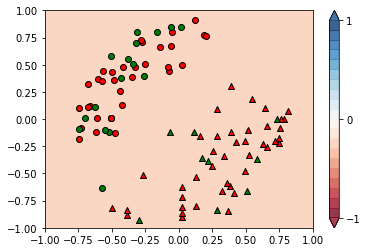

In [26]:
import matplotlib.pyplot as plt

plt.figure()
cm = plt.cm.RdBu

# make data for decision regions
xx, yy = np.meshgrid(np.linspace(-1.1, 1.1, 20), np.linspace(-1.1, 1.1, 20))
X_grid = [np.array([x, y]) for x, y in zip(xx.flatten(), yy.flatten())]
predictions_grid = [variational_classifier(weights, x=x) for x in X_grid]
Z = np.reshape(predictions_grid, xx.shape)

# plot decision regions
cnt = plt.contourf(xx, yy, Z, levels=np.arange(-1, 1.1, 0.1), cmap=cm, alpha=.8, extend='both')
plt.colorbar(cnt, ticks=[-1, 0, 1])

# plot data
trf0 = [d for i, d in enumerate(X_train) if Y_train[i] == -1]
trf1 = [d for i, d in enumerate(X_train) if Y_train[i] == 1]
plt.scatter([c[0] for c in trf1], [c[1] for c in trf1], c='r', marker='^', edgecolors='k')
plt.scatter([c[0] for c in trf0], [c[1] for c in trf0], c='r', marker='o', edgecolors='k')
tes0 = [d for i, d in enumerate(X_val) if Y_val[i] == -1]
tes1 = [d for i, d in enumerate(X_val) if Y_val[i] == 1]
plt.scatter([c[0] for c in tes1], [c[1] for c in tes1], c='g', marker='^', edgecolors='k')
plt.scatter([c[0] for c in tes0], [c[1] for c in tes0], c='g', marker='o', edgecolors='k')

plt.xlim(-1, 1)
plt.ylim(-1, 1)